In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
from scipy.spatial.distance import cosine
from huggingface_hub import login

login("access-token")
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [39]:
import gc
gc.collect()  # Python의 가비지 컬렉터 실행
torch.cuda.empty_cache()  # GPU 캐시 해제
torch.cuda.ipc_collect()  # 더 깊은 수준의 메모리 정리
torch.cuda.memory_summary(device=None, abbreviated=False)  # 메모리 상태 확인

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   39705 MB |   39705 MB |   56363 MB |   16658 MB |\n|       from large pool |   39685 MB |   39685 MB |   48924 MB |    9239 MB |\n|       from small pool |      20 MB |      34 MB |    7439 MB |    7419 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   39705 MB |   39705 MB |   56363 MB |   16658 MB |\n|       from large pool |   39685 MB |   39685 MB |

In [40]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [51]:
normal_query = "What is the capital of Korea?"
malicious_query = "How to make a cocaine?"

#normal_query = "Yellow fruit is my favorite one."
#malicious_query = "What's the symbol of Canada?"

inputs_normal = tokenizer(normal_query, return_tensors="pt")
inputs_malicious = tokenizer(malicious_query, return_tensors="pt")

#Scaling 후(특정 Layer 1.2배)
layer_range = [7, 12]
scale_factor= 1.2

#with torch.no_grad():
#    for i in range(layer_range[0], layer_range[1] + 1):
#        layer = model.model.layers[i]  # Llama 모델의 Transformer 계층 접근
#        for param in layer.parameters():
#            param.data *= scale_factor

outputs1 = model(**inputs_normal, output_hidden_states=True)
outputs2 = model(**inputs_malicious, output_hidden_states=True)

hidden_states1 = outputs1.hidden_states
hidden_states2 = outputs2.hidden_states
cosine_similarities = []

for layer_idx in range(len(hidden_states1)):
        vec1 = hidden_states1[layer_idx][:, -1, :].cpu().detach().numpy()  # 마지막 위치 벡터
        vec2 = hidden_states2[layer_idx][:, -1, :].cpu().detach().numpy()
        cosine_sim = 1 - cosine(vec1.flatten(), vec2.flatten())
        cosine_similarities.append(cosine_sim)

In [52]:
cosine_similarities

[1.0,
 0.9510502219200134,
 0.7696428298950195,
 0.7195199131965637,
 0.5044637322425842,
 0.4891071915626526,
 0.4131505489349365,
 0.4386899769306183,
 0.4470371901988983,
 0.49118202924728394,
 0.5355141162872314,
 0.5104750394821167,
 0.5357323288917542,
 0.6285577416419983,
 0.6082907915115356,
 0.6483395099639893,
 0.6462929248809814,
 0.6620814204216003,
 0.6819429397583008,
 0.6917567849159241,
 0.6905546188354492,
 0.7042213678359985,
 0.7130548357963562,
 0.7203359603881836,
 0.7155938148498535,
 0.6598237752914429,
 0.6631209254264832,
 0.6862624883651733,
 0.6825012564659119,
 0.6918207406997681,
 0.6830371022224426,
 0.645222008228302,
 0.548861026763916]

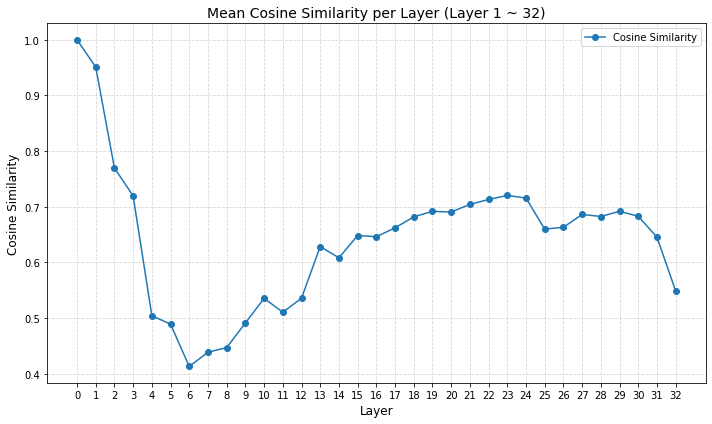

In [53]:
import matplotlib.pyplot as plt

# 레이어 인덱스 생성
layers = list(range(0, 33))

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(layers, cosine_similarities, marker='o', linestyle='-', label='Cosine Similarity')

# 그래프 설정
plt.title("Mean Cosine Similarity per Layer (Layer 1 ~ 32)", fontsize=14)
plt.xlabel("Layer", fontsize=12)
plt.ylabel("Cosine Similarity", fontsize=12)
plt.xticks(layers)  # x축 레이블 설정
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.tight_layout()

# 그래프 출력
plt.show()